In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Import annotation, reference, and ancestral data

In [2]:
## annotations from UKB
annotations = pd.read_csv("../metadata/ukb23158_500k_OQFE.annotations.txt", delimiter=" ", header=None, names=["Variant", "Gene_Annotation", "Functional"])
annotations['CHROM'] = annotations['Variant'].apply(lambda x: x.split(':')[0].strip())
annotations['POS'] = annotations['Variant'].apply(lambda x: int(x.split(':')[1].split(':')[0].strip()))

In [3]:
## grch38 reference genome
reference = pd.read_csv('../metadata/ref_vars_grch38_chr1.txt',delimiter='\t')
reference = reference.rename(columns={'ANCESTRAL':'REFERENCE_GRCH38','CHR':'CHROM'})
# reference

In [4]:
# ancestral genome from ensembl
ancestral = pd.read_csv("../metadata/ancestral_vars_chr1.txt",delimiter='\t')
ancestral = ancestral.rename(columns={'CHR':'CHROM'})
# ancestral

In [5]:
## formatting
annotations['CHROM']=annotations['CHROM'].astype(int)
reference['CHROM']=reference['CHROM'].astype(int)
ancestral['CHROM']=ancestral['CHROM'].astype(int)
ancestral["ANCESTRAL"] = ancestral["ANCESTRAL"].str.upper()  # Ensure uppercase
ancestral = ancestral[~ancestral["ANCESTRAL"].isin(["N", ".", "-"])]  # Remove unwanted values

In [6]:
## merge
df = annotations.merge(reference, on=["CHROM", "POS"], suffixes=("", "_grch38"))
df = df.merge(ancestral, on=["CHROM", "POS"])

In [7]:
## compute AncRef/DerRef status
df[["chrom", "pos", "A2", "A1"]] = df["Variant"].str.split(":", expand=True)
df["pos"] = df["pos"].astype(int)
valid_bases = {"A", "T", "C", "G"}
df = df[df["A2"].isin(valid_bases) & df["A1"].isin(valid_bases)]
df['CHROM'] = df['CHROM'].astype(int)
df["status"] = df.apply(
    lambda row: "AncRef" if row["ANCESTRAL"] == row["REFERENCE_GRCH38"]
    else ("DerRef" if row["A1"] == row["ANCESTRAL"] else "other"),
    axis=1
)
# df

In [164]:
# df

### Frequencies - all UKB

In [190]:
## allele frequencies from whole UKB - process
frequency_ALL = pd.read_csv('../data/chr1_ukb_all_kao.frqx',delimiter='\t')
frequency_ALL['FRQ_A1'] = (2 * frequency_ALL['C(HOM A1)'] + frequency_ALL['C(HET)']) / (2 * (frequency_ALL['C(HOM A1)'] + frequency_ALL['C(HET)'] + frequency_ALL['C(HOM A2)']))
frequency_ALL['FRQ_A2'] = (2 * frequency_ALL['C(HOM A2)'] + frequency_ALL['C(HET)']) / (2 * (frequency_ALL['C(HOM A1)'] + frequency_ALL['C(HET)'] + frequency_ALL['C(HOM A2)']))
frequency_ALL[['CHROM', 'POS', 'A2_SNP', 'A1_SNP']] = frequency_ALL['SNP'].str.split(':', expand=True)
frequency_ALL['CHROM']=frequency_ALL['CHROM'].astype(int)
frequency_ALL['POS'] = frequency_ALL['POS'].astype(int)
# frequency_ALL

In [191]:
## merge with annotations
df_freq_ALL = df.merge(frequency_ALL[['CHROM', 'POS', 'A1', 'A2', 'FRQ_A1','FRQ_A2']], on=['CHROM', 'POS', 'A1', 'A2'], how='left')
df_freq_ALL_filt = df_freq_ALL[df_freq_ALL['status']!='other']

## MAF
df_freq_ALL_filt['MAF'] = df_freq_ALL_filt[['FRQ_A1', 'FRQ_A2']].min(axis=1)

In [193]:
# df_freq_ALL_filt['MAF'].max()

0.4998343200237086

In [194]:
## compute heterozygosity from MAF
df_freq_ALL_filt['HET']=2*df_freq_ALL_filt['MAF']*(1-df_freq_ALL_filt['MAF'])

In [197]:
df_freq_ALL_filt['HET'].max()

0.49999994510029094

In [200]:
# df_freq_ALL_filt[df_freq_ALL_filt['HET']==0.49999994510029094]

In [201]:
num_bins=15
het_bins = np.linspace(0, 0.5, num_bins + 1)
het_labels = [f"[{het_bins[i]:.4f}, {het_bins[i+1]:.4f})" for i in range(len(het_bins) - 1)]
het_labels

['[0.0000, 0.0333)',
 '[0.0333, 0.0667)',
 '[0.0667, 0.1000)',
 '[0.1000, 0.1333)',
 '[0.1333, 0.1667)',
 '[0.1667, 0.2000)',
 '[0.2000, 0.2333)',
 '[0.2333, 0.2667)',
 '[0.2667, 0.3000)',
 '[0.3000, 0.3333)',
 '[0.3333, 0.3667)',
 '[0.3667, 0.4000)',
 '[0.4000, 0.4333)',
 '[0.4333, 0.4667)',
 '[0.4667, 0.5000)']

In [202]:
## compute heterozygosity bins
df_freq_ALL_filt['HET_bin'] = pd.cut(df_freq_ALL_filt['HET'], bins=het_bins, labels=het_labels, right=False)
# df_freq_ALL_filt

In [203]:
## format functional categories
df_freq_ALL_filt['Functional_cat'] = df_freq_ALL_filt['Functional'].apply(
    lambda x: 'Missense' if 'mis' in x else ('Synonymous' if 'syn' in x else ('LoF' if 'LoF' in x else 'Other'))
)

In [204]:
## compute proportions of mis/syn/lof in het bins
colnames=['status','HET_bin','prop_syn','prop_mis','prop_lof','num_snps']
fcat=['Synonymous','Missense','LoF']
res_ALL = pd.DataFrame(columns=colnames)

for hbin in het_labels:
    for stat in ['AncRef','DerRef']:
        temp = df_freq_ALL_filt[(df_freq_ALL_filt['status']==stat) & (df_freq_ALL_filt['HET_bin']==hbin)]
        allele_count = len(temp)
        if len(temp)>0:
            prop_func = temp['Functional_cat'].value_counts(normalize=True).reindex(fcat, fill_value=0).tolist() # order is Syn Mis LoF
            row = [stat,hbin,prop_func[0],prop_func[1],prop_func[2],allele_count]
        else:
            row = [stat,hbin,np.nan,np.nan,np.nan,allele_count]
        temp_df = pd.DataFrame([row], columns=colnames)
        res_ALL = pd.concat([res_ALL, temp_df], ignore_index=True)

In [205]:
res_ALL

,status,HET_bin,prop_syn,prop_mis,prop_lof,num_snps
0,AncRef,"[0.0000, 0.0333)",0.300525,0.659709,0.039766,781499
1,DerRef,"[0.0000, 0.0333)",0.560708,0.437605,0.001686,2372
2,AncRef,"[0.0333, 0.0667)",0.420970,0.572770,0.006260,639
3,DerRef,"[0.0333, 0.0667)",0.551020,0.448980,0.000000,49
4,AncRef,"[0.0667, 0.1000)",0.459701,0.519403,0.020896,335
5,DerRef,"[0.0667, 0.1000)",0.510638,0.489362,0.000000,47
6,AncRef,"[0.1000, 0.1333)",0.436681,0.541485,0.021834,229
7,DerRef,"[0.1000, 0.1333)",0.680000,0.320000,0.000000,50
8,AncRef,"[0.1333, 0.1667)",0.520468,0.479532,0.000000,171
9,DerRef,"[0.1333, 0.1667)",0.586957,0.413043,0.000000,46


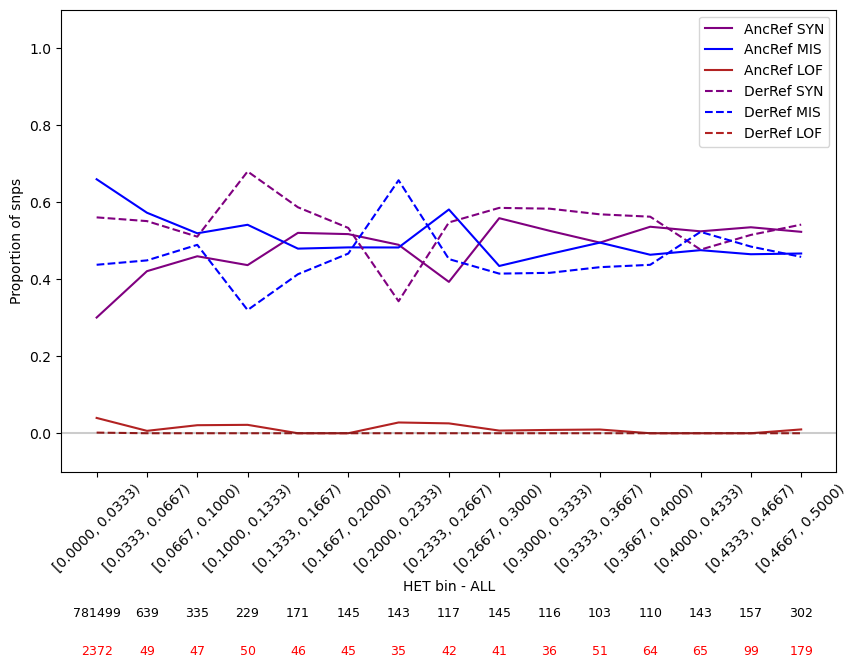

In [206]:
## plot of proportions by AncRef/DerRef

linestyle_map = {'AncRef':'-','DerRef':'--'}

plt.figure(figsize=(10,6))
for status in res_ALL['status'].unique():
    status_data = res_ALL[res_ALL['status'] == status]  
    plt.plot(status_data['HET_bin'], status_data['prop_syn'], linestyle=linestyle_map[status], label=f'{status} SYN',color='purple')
    plt.plot(status_data['HET_bin'], status_data['prop_mis'], linestyle=linestyle_map[status], label=f'{status} MIS',color='blue')
    plt.plot(status_data['HET_bin'], status_data['prop_lof'], linestyle=linestyle_map[status], label=f'{status} LOF',color='firebrick')

for i, row in res_ALL[res_ALL['status'] == 'AncRef'].iterrows():
    plt.text(row['HET_bin'], -0.45, str(row['num_snps']), ha='center', va='top', fontsize=9, color='black')

for i, row in res_ALL[res_ALL['status'] == 'DerRef'].iterrows():
    plt.text(row['HET_bin'], -0.55, str(row['num_snps']), ha='center', va='top', fontsize=9, color='red')
    
plt.legend()
plt.ylim(-0.1,1.1)
plt.xticks(rotation=45)
plt.axhline(0,color='black',alpha=0.2)
plt.xlabel('HET bin - ALL')
plt.ylabel('Proportion of snps')
# plt.savefig('freq_binned_ALL_nosyn.pdf')
plt.show()

### Apply correction

In [207]:
## add proportions to dataframe
prop_func_binned = res_ALL[res_ALL['status']=='AncRef']
df_freq_ALL_filt_props = df_freq_ALL_filt.merge(
    prop_func_binned[['HET_bin', 'prop_lof','prop_syn','prop_mis']], 
    on='HET_bin', 
    how='left', 
    suffixes=('', '_anc')
)

In [230]:
# df_freq_ALL_filt_props

In [228]:
def bias_corr_het_direct(df_freq_ALL_filt_props, lof_file, mis_file, syn_file, rep=1):
    # Read the input files for each category (LOF, missense, synonymous) and format
    dflof = pd.read_csv(lof_file, sep='\s+')
    dflof = dflof.rename(columns={'CHR': 'CHROM', 'FREQ': 'MAF_SIR'})
    dflof['HET_SIR'] = 2 * dflof['MAF_SIR'] * (1 - dflof['MAF_SIR'])
    df_all_lof = df_freq_ALL_filt_props.merge(dflof, on=['CHROM', 'POS'], how='inner', suffixes=('', '_sir'))
    df_all_lof_rep = df_all_lof[df_all_lof['ITER'] == rep]

    dfmis = pd.read_csv(mis_file, sep='\s+')
    dfmis = dfmis.rename(columns={'CHR': 'CHROM', 'FREQ': 'MAF_SIR'})
    dfmis['HET_SIR'] = 2 * dfmis['MAF_SIR'] * (1 - dfmis['MAF_SIR'])
    df_all_mis = df_freq_ALL_filt_props.merge(dfmis, on=['CHROM', 'POS'], how='inner', suffixes=('', '_sir'))
    df_all_mis_rep = df_all_mis[df_all_mis['ITER'] == rep]

    dfsyn = pd.read_csv(syn_file, sep='\s+')
    dfsyn = dfsyn.rename(columns={'CHR': 'CHROM', 'FREQ': 'MAF_SIR'})
    dfsyn['HET_SIR'] = 2 * dfsyn['MAF_SIR'] * (1 - dfsyn['MAF_SIR'])
    df_all_syn = df_freq_ALL_filt_props.merge(dfsyn, on=['CHROM', 'POS'], how='inner', suffixes=('', '_sir'))
    df_all_syn_rep = df_all_syn[df_all_syn['ITER'] == rep]

    # Combine the data
    df_all_rep = pd.concat([df_all_syn_rep, df_all_mis_rep, df_all_lof_rep])
    
    # Subset the relevant columns
    df_all_rep_sub = df_all_rep[['CHROM', 'POS', 'Functional_cat', 'status', 'MAF', 'MAF_SIR', 'HET_SIR', 'prop_lof', 'prop_mis', 'prop_syn']]

    # Split by AncRef and DerRef
    df_AncRef = df_all_rep_sub[df_all_rep_sub['status'] == 'AncRef']
    df_DerRef = df_all_rep_sub[df_all_rep_sub['status'] == 'DerRef']

    # For DerRef variants, directly correct HET using the functional category proportions
    df_DerRef['corrected_HET_lof'] = df_DerRef['HET_SIR'] * df_DerRef['prop_lof']
    df_DerRef['corrected_HET_mis'] = df_DerRef['HET_SIR'] * df_DerRef['prop_mis']
    df_DerRef['corrected_HET_syn'] = df_DerRef['HET_SIR'] * df_DerRef['prop_syn']

    # For AncRef variants, use original HET as no correction is needed
    df_AncRef['corrected_HET_lof'] = df_AncRef.apply(lambda row: row['HET_SIR'] if row['Functional_cat'] == 'LoF' else np.nan, axis=1)
    df_AncRef['corrected_HET_mis'] = df_AncRef.apply(lambda row: row['HET_SIR'] if row['Functional_cat'] == 'Missense' else np.nan, axis=1)
    df_AncRef['corrected_HET_syn'] = df_AncRef.apply(lambda row: row['HET_SIR'] if row['Functional_cat'] == 'Synonymous' else np.nan, axis=1)

    # Combine AncRef and DerRef dataframes
    df_combined = pd.concat([df_AncRef, df_DerRef], axis=0)

    return df_combined


In [217]:
scenario='uniformpca'
lof_file = f'../results/freq/chr1_lof_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
mis_file = f'../results/freq/chr1_missense_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
syn_file = f'../results/freq/chr1_synonymous_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
df_combined_rep = bias_corr_het_direct(df_freq_ALL_filt_props, lof_file, mis_file, syn_file, rep=5)
print(df_combined_rep[df_combined_rep['status']=='AncRef']['corrected_HET_lof'].mean())
print(df_combined_rep[df_combined_rep['status']=='DerRef']['corrected_HET_lof'].mean())
print(df_combined_rep['corrected_HET_lof'].mean())

0.0002532594434415018
2.3308956710287707e-05
0.0002509183103005267


In [108]:
# df_combined_rep

In [218]:
scenario='centerX19Y4pca0.0015'
lof_file = f'../results/freq/chr1_lof_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
mis_file = f'../results/freq/chr1_missense_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
syn_file = f'../results/freq/chr1_synonymous_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
df_combined_rep = bias_corr_het_direct(df_freq_ALL_filt_props, lof_file, mis_file, syn_file, rep=5)
print(df_combined_rep[df_combined_rep['status']=='AncRef']['corrected_HET_lof'].mean())
print(df_combined_rep[df_combined_rep['status']=='DerRef']['corrected_HET_lof'].mean())
print(df_combined_rep['corrected_HET_lof'].mean())

0.00022563867219610657
1.3274468490073665e-05
0.00022347658555597644


[0.00020713735163862003, 0.00020640630612561104, 0.00020573746549072398, 0.00020388512368467302, 0.00020329208749203897, 0.00020348629104849537, 0.00020380793273416702, 0.00020458020920055068, 0.00020458110661912467, 0.0002037192756480229, 0.00023020305839469027, 0.00023699414091275244, 0.0002494858442623776, 0.00025997762576954696]
[0.0010444450488517787, 0.0010441912748627086, 0.0010444189355985137, 0.001044578799782809, 0.0010429095305942277, 0.0010434784781006153, 0.00104467512976364, 0.0010456473559349966, 0.0010453952506474988, 0.001043460930174887, 0.0011165149326211904, 0.0011549596231129426, 0.001221202660431655, 0.0012764053471400283]
[0.0015563182274020405, 0.0015574043969950944, 0.0015556737252802716, 0.0015527994559795138, 0.0015528605521618279, 0.001553761980394365, 0.0015475659222364524, 0.001552018349377564, 0.0015533098582800916, 0.0015548784897702738, 0.0017013368592266025, 0.0017906860803739363, 0.0019337083619665406, 0.0020699240412486077]


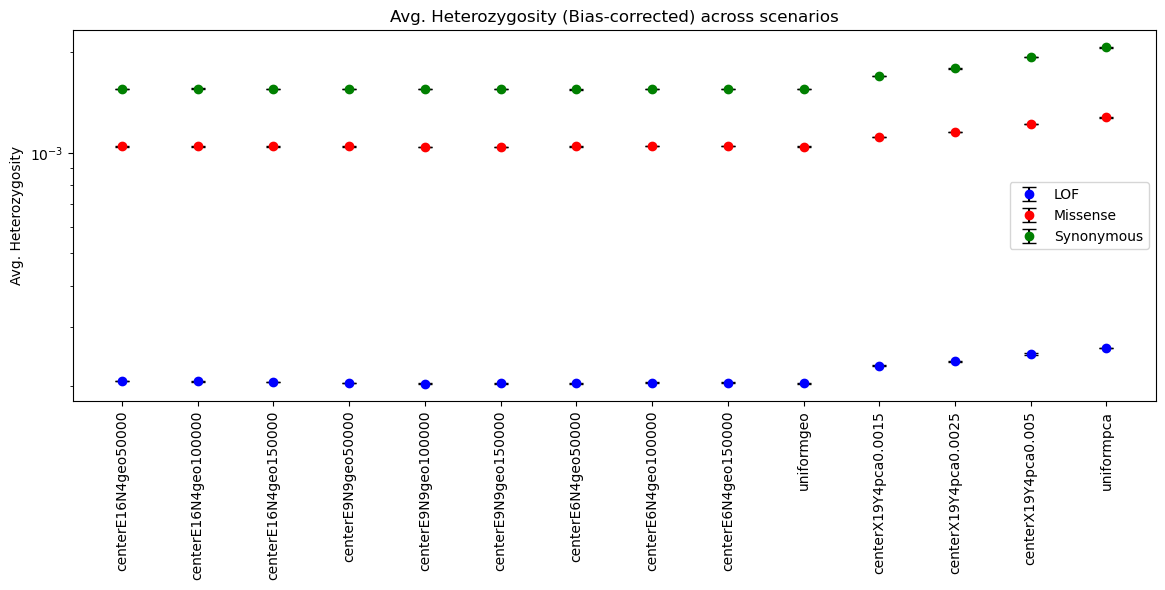


Percent change from uniformgeo to uniformpca:
LOF: 27.62%
Missense: 22.32%
Synonymous: 33.12%

Percent change from uniformgeo to centerX19Y4pca0.0015:
LOF: 13.00%
Missense: 7.00%
Synonymous: 9.42%

Percent change from centerE16N4geo50000 to uniformgeo:
LOF: -1.65%
Missense: -0.09%
Synonymous: -0.09%

Percent change from centerE9N9geo50000 to uniformgeo:
LOF: -0.08%
Missense: -0.11%
Synonymous: 0.13%

Percent change from centerX19Y4pca0.0015 to uniformpca:
LOF: 12.93%
Missense: 14.32%
Synonymous: 21.66%

Percent change from centerE16N4geo50000 to uniformpca:
LOF: 25.51%
Missense: 22.21%
Synonymous: 33.00%


In [229]:
def plot_bias_corrected_het_for_scenarios(df_freq_ALL_filt_props):
    plt.figure(figsize=(12, 6))
    
    # Order of scenarios
    custom_order = [
        'centerE16N4geo50000', 'centerE16N4geo100000', 'centerE16N4geo150000',
        'centerE9N9geo50000', 'centerE9N9geo100000', 'centerE9N9geo150000',
        'centerE6N4geo50000', 'centerE6N4geo100000', 'centerE6N4geo150000',
        'uniformgeo',
        'centerX19Y4pca0.0015', 'centerX19Y4pca0.0025', 'centerX19Y4pca0.005',
        'uniformpca'
    ]
    
    # Colors for each category
    colors = {'LOF': 'blue', 'Missense': 'red', 'Synonymous': 'green'}
    
    # Initialize lists to hold mean frequencies and standard deviations
    means_lof = []
    means_mis = []
    means_syn = []
    stds_lof = []
    stds_mis = []
    stds_syn = []

    # Loop through each scenario
    for scenario in custom_order:
        # Construct file paths for LOF, Missense, and Synonymous
        lof_file = f'../results/freq/chr1_lof_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
        mis_file = f'../results/freq/chr1_missense_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
        syn_file = f'../results/freq/chr1_synonymous_{scenario}_nSIR10000_nSIRreps10.SIRfreq'
        
        # Collect mean DAF values across replicates
        lof_het = []
        mis_het = []
        syn_het = []
        
        # Loop through replicates 1 through 10
        for rep in range(1, 11):
            # Get the corrected data for the current replicate
            df_combined_rep = bias_corr_het_direct(df_freq_ALL_filt_props, lof_file, mis_file, syn_file,rep)
            
            # Calculate the means for each functional category
            mean_lof = df_combined_rep['corrected_HET_lof'].mean()
            mean_mis = df_combined_rep['corrected_HET_mis'].mean()
            mean_syn = df_combined_rep['corrected_HET_syn'].mean()
            
            # Append to the lists
            lof_het.append(mean_lof)
            mis_het.append(mean_mis)
            syn_het.append(mean_syn)
        
        # Calculate the mean and standard deviation of the means across replicates
        means_lof.append(np.mean(lof_het))
        means_mis.append(np.mean(mis_het))
        means_syn.append(np.mean(syn_het))
        stds_lof.append(np.std(lof_het))
        stds_mis.append(np.std(mis_het))
        stds_syn.append(np.std(syn_het))

    print(means_lof)
    print(means_mis)
    print(means_syn)
    
    # Plot the results
    plt.errorbar(custom_order, means_lof, yerr=stds_lof, fmt='o', capsize=5, color=colors['LOF'], ecolor='black', label='LOF')
    plt.errorbar(custom_order, means_mis, yerr=stds_mis, fmt='o', capsize=5, color=colors['Missense'], ecolor='black', label='Missense')
    plt.errorbar(custom_order, means_syn, yerr=stds_syn, fmt='o', capsize=5, color=colors['Synonymous'], ecolor='black', label='Synonymous')
    
    # Final plot adjustments
    plt.xticks(rotation=90)
    plt.title("Avg. Heterozygosity (Bias-corrected) across scenarios")
    plt.ylabel("Avg. Heterozygosity")
    plt.legend()
    plt.tight_layout()
    plt.yscale('log')
    # plt.ylim(1e-4, 1e-2)
    plt.show()
    
    # Get indices for comparisons
    idx_uniformgeo = custom_order.index('uniformgeo')
    idx_uniformpca = custom_order.index('uniformpca')
    idx_pca_0015 = custom_order.index('centerX19Y4pca0.0015')
    idx_geo_50000 = custom_order.index('centerE16N4geo50000')
    idx_geo_50000_2 = custom_order.index('centerE9N9geo50000')
    
    # Print percent change from uniformgeo to uniformpca
    print("\nPercent change from uniformgeo to uniformpca:")
    print(f"LOF: {((means_lof[idx_uniformpca] - means_lof[idx_uniformgeo]) / means_lof[idx_uniformgeo]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformpca] - means_mis[idx_uniformgeo]) / means_mis[idx_uniformgeo]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformpca] - means_syn[idx_uniformgeo]) / means_syn[idx_uniformgeo]) * 100:.2f}%")
    
    # Print percent change from uniformgeo to centerX19Y4pca0.0015
    print("\nPercent change from uniformgeo to centerX19Y4pca0.0015:")
    print(f"LOF: {((means_lof[idx_pca_0015] - means_lof[idx_uniformgeo]) / means_lof[idx_uniformgeo]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_pca_0015] - means_mis[idx_uniformgeo]) / means_mis[idx_uniformgeo]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_pca_0015] - means_syn[idx_uniformgeo]) / means_syn[idx_uniformgeo]) * 100:.2f}%")
    
    # Print percent change from centerE16N4geo50000 to uniformgeo
    print("\nPercent change from centerE16N4geo50000 to uniformgeo:")
    print(f"LOF: {((means_lof[idx_uniformgeo] - means_lof[idx_geo_50000]) / means_lof[idx_geo_50000]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformgeo] - means_mis[idx_geo_50000]) / means_mis[idx_geo_50000]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformgeo] - means_syn[idx_geo_50000]) / means_syn[idx_geo_50000]) * 100:.2f}%")

     # Print percent change from centerE9N9geo50000 to uniformgeo
    print("\nPercent change from centerE9N9geo50000 to uniformgeo:")
    print(f"LOF: {((means_lof[idx_uniformgeo] - means_lof[idx_geo_50000_2]) / means_lof[idx_geo_50000_2]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformgeo] - means_mis[idx_geo_50000_2]) / means_mis[idx_geo_50000_2]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformgeo] - means_syn[idx_geo_50000_2]) / means_syn[idx_geo_50000_2]) * 100:.2f}%")
    
    # Print percent change from centerX19Y4pca0.0015 to uniformpca
    print("\nPercent change from centerX19Y4pca0.0015 to uniformpca:")
    print(f"LOF: {((means_lof[idx_uniformpca] - means_lof[idx_pca_0015]) / means_lof[idx_pca_0015]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformpca] - means_mis[idx_pca_0015]) / means_mis[idx_pca_0015]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformpca] - means_syn[idx_pca_0015]) / means_syn[idx_pca_0015]) * 100:.2f}%")
    
    # Print percent change from centerE16N4geo50000 to uniformpca
    print("\nPercent change from centerE16N4geo50000 to uniformpca:")
    print(f"LOF: {((means_lof[idx_uniformpca] - means_lof[idx_geo_50000]) / means_lof[idx_geo_50000]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformpca] - means_mis[idx_geo_50000]) / means_mis[idx_geo_50000]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformpca] - means_syn[idx_geo_50000]) / means_syn[idx_geo_50000]) * 100:.2f}%")



# Call the plotting function with the required dataframe
plot_bias_corrected_het_for_scenarios(df_freq_ALL_filt_props)